# Notebook recommender system

## Packages and import

In [375]:
#pip install tensorflow==2.15.0

### POUR VISUALISATION ###

#!pip install seaborn
#!pip install umap-learn
!pip install pacmap
!pip install numba==0.57

In [379]:
import pandas as pd
import numpy as np

from warnings import simplefilter
from sklearn.preprocessing import LabelEncoder
# Ignore warnings below
# Optimisation via tensorflow.keras
from tensorflow.keras.layers import Input, Dot, Embedding, Add, Flatten, Activation, Layer
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import Callback
pd.options.mode.chained_assignment = None  # default='warn' # Remove copy on slice warning
import tensorflow as tf
from keras import regularizers

# Pour visualisation
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import umap.umap_ as umap
import pacmap


## Graph formation without HNS

In [252]:
def graph_formation(n_patients,
                    n_doctors,
                    max_number_connections,
                    z=1.4,
                    type_distance="default",
                    beta_age_p_graph=0.01,
                    beta_age_d_graph=0.01,
                    beta_sex_p_graph=0.5,
                    beta_sex_d_graph=0.5,
                    beta_distance_graph=-0.5,

                    alpha_law_weights = [0.2, 0.4, 0.4],
                    alpha_law_means = np.array([[1., 0., 0., 0., 1.],
                                        [0., 1., 1., 0., 0.],
                                        [0., 1., 1., 1., 1.]]) ,
                    alpha_law_cov = None,
                    
                    psi_law_weights = [0.4, 0.6],
                    psi_law_means = np.array([[0., 0., 1., 0., 1.],
                                       [1., 0., 1., 0., 0.]]),
                    psi_law_cov = None,
                    nb_latent_factors = 5,
                   ):

    """Génère un dataframe contenant l'ensemble des connexions/inexistantes entre les patients/docteurs selon un modèle logistique.

    Args:
        n_patients (int): Le nombre de patients
        n_doctors (int): Le nombre de docteurs
        max_number_connections (int): Le nombre max de connexions par patient que l'on autorise
        z (float, optional): Le seuil de distance maximale pour lequel on autorise connexion. Defaults to 1.4.
        type_distance (str, optional): Permet de définir la manière dont on génère la distance (par défaut, on génère des points dans [0, 1] x [0, 1]),
        sinon on utilise les CODGEO de l'INSEE. Defaults to "default".
        beta_age_p_graph (float, optional): le paramètre du modèle associé à l'âge des patients. Defaults to 0.01.
        beta_age_d_graph (float, optional): le paramètre du modèle associé à l'âge des docteurs. Defaults to 0.01.
        beta_sex_p_graph (float, optional): le paramètre du modèle associé au sexe des patients. Defaults to 0.5.
        beta_sex_d_graph (float, optional): le paramètre du modèle associé au sexe des docteurs. Defaults to 0.5.
        beta_distance_graph (float, optional): le paramètre du modèle associé à la distance. Defaults to -0.5.
        alpha_law_graph (tuple, optional): les bornes de la loi uniforme pour la génération de l'effet fixe des patients. Defaults to (-1, 1).
        psi_law_graph (tuple, optional): les bornes de la loi uniforme pour la génération de l'effet fixe des docteurs. Defaults to (-1, 1).
        nb_latent_factors (_type_, optional): Le nombre de vecteurs latents, par défaut, on les génère aléatoirement. Defaults to None.

    Returns:
        _type_: Le dataframe voulu.
    """

    coor_patients = []
    coor_doctors = []
    
    alpha_graph = np.zeros((n_patients,nb_latent_factors))
    alpha_class = []
    
    psi_graph =  np.zeros((n_doctors,nb_latent_factors))
    psi_class = []

    rng = np.random.default_rng(None)
    D = np.zeros([n_patients, n_doctors], dtype = np.ndarray)

    # Change the weights to numpy array (if it is not already the case)
    alpha_law_weights =  np.array(alpha_law_weights)
    psi_law_weights =  np.array(psi_law_weights)

    # To be sure that weights are normalized
    alpha_law_weights = alpha_law_weights / alpha_law_weights.sum()
    psi_law_weights = psi_law_weights / psi_law_weights.sum()

    if alpha_law_cov == None:
        alpha_law_cov = np.eye(nb_latent_factors)*0.3

    if psi_law_cov == None:
        psi_law_cov = np.eye(nb_latent_factors)*0.3

     #Count the number of class possible
    nb_class_alpha = len(alpha_law_weights)
    nb_class_psi = len(psi_law_weights)
        
    for i in range(n_patients):
        
        # Assign randomly a class with respect to the distribution given by the weights
        alpha_class.append( np.random.choice( np.arange(nb_class_alpha), p=alpha_law_weights) )

        mean = alpha_law_means[alpha_class[-1]]
        cov = alpha_law_cov
        # We generate the FE for the graph formation model
        alpha_graph[i] =  np.random.multivariate_normal(mean, cov, size=1)


    for i in range(n_doctors):
            
            # Assign randomly a class with respect to the distribution given by the weights
            psi_class.append( np.random.choice( np.arange(nb_class_psi), p=psi_law_weights) )
    
            mean = psi_law_means[psi_class[-1]]
            cov = psi_law_cov
            # We generate the FE for the graph formation model
            psi_graph[i] =  np.random.multivariate_normal(mean, cov, size=1)




    # Generate distance matrix
    if type_distance == 'default':
        for i in range(n_patients):
            # Generate the coordinates of the patients
            coor_patients.append( np.random.uniform(0, 1, 2) )
            for j in range(n_doctors):
                if i == 0: # We ensure each coordinate is generated once for each doctor
                    # Generate the coordinates of the doctors
                    coor_doctors.append( np.random.uniform(0, 1, 2) )
                d = np.sqrt(np.power((coor_patients[i][0] - coor_doctors[j][0]), 2) + np.power((coor_patients[i][1] - coor_doctors[j][1]), 2))
                D[i][j] = d

    else:

        # Assign randomly a CODGEO, DEP, or REG to patients and doctors
        dist_matrix = pd.read_csv('../Data/' + type_distance + '.csv')
        
        del dist_matrix[dist_matrix.columns[0]]
        dist_matrix.index = dist_matrix.columns
        for i in range(len(dist_matrix)):
            dist_matrix.iloc[i, i] = 0
        arr = dist_matrix.columns.values
        for i, col in enumerate(arr):
            arr[i] = int(float(arr[i]))
        dist_matrix.columns = arr
        dist_matrix.index = arr

        # Generate code for patient and doctor
        code_patient = []
        code_doctor = []
        for i in range(n_patients):
            random_code = np.random.choice(dist_matrix.columns.values)
            code_patient.append( random_code )
        for j in range(n_doctors):
            random_code = np.random.choice(dist_matrix.columns.values)
            code_doctor.append( random_code )
        for i in range(n_patients):
            for j in range(n_doctors):
                D[i, j] = dist_matrix.loc[code_patient[i], code_doctor[j]]

    # D_normed = ( D - D.mean() ) / D.std()
    # Random draws of ages for patients and doctors
    sim_patient_age = rng.integers(low = 1, high = 99, size = n_patients)
    sim_patient_age_normed = ( sim_patient_age - sim_patient_age.mean() ) / sim_patient_age.std()
    sim_doctor_age = rng.integers(low = 26, high = 99, size = n_doctors)
    sim_doctor_age_normed = ( sim_doctor_age - sim_doctor_age.mean() ) / sim_doctor_age.std()

    # Random draws of genders of patients and doctors
    sim_patient_gender = np.random.choice(np.array([0, 1]), n_patients)
    sim_doctor_gender = np.random.choice(np.array([0, 1]), n_doctors)
    sim_patient_gender_normed = ( sim_patient_gender - sim_patient_gender.mean() ) / sim_patient_gender.std()
    sim_doctor_gender_normed = ( sim_doctor_gender - sim_doctor_gender.mean() ) / sim_doctor_gender.std()

    # Compile ids
    id_p = np.repeat(range(n_patients), n_doctors)
    id_d = np.tile(range(n_doctors), n_patients)

    # Compile observed features
    age_p_data = np.repeat(sim_patient_age, n_doctors)
    age_d_data = np.tile(sim_doctor_age, n_patients)
    sex_p_data = np.repeat(sim_patient_gender, n_doctors)
    sex_d_data = np.tile(sim_doctor_gender, n_patients)
    if type_distance != 'default':
        code_patient_data = np.repeat(code_patient, n_doctors)
        code_doctor_data = np.tile(code_doctor, n_patients)
    # # P is the matrix with all the connection probabilities
    # P = np.zeros((n_patients, n_doctors))
    # Generate the identifier matrix A based on the distance
    A = np.zeros([n_patients, n_doctors], dtype = np.ndarray)
    for i in range(n_patients):
        for j in range(n_doctors):
            if D[i][j] <= z: # if patient i and doctor j are too far away, there is no relation
                T = np.dot(alpha_graph[i], psi_graph[j]) + beta_age_p_graph * sim_patient_age_normed[i] + beta_age_d_graph * sim_doctor_age_normed[j] \
                + beta_sex_p_graph * sim_patient_gender_normed[i] + beta_sex_d_graph * sim_doctor_gender_normed[j] + beta_distance_graph * D[i][j]
                p = 1 / (1 + np.exp(-T))
                # P[i][j] = p
                A[i][j] = np.random.binomial(1, p)
    
    # Compile relations between doctors and patients
    relation = A.flatten()

    # Merge all columns into a dataframe
    dataframe = pd.DataFrame(data={'i': id_p, 'j': id_d, 'y' : relation, 'age_p': age_p_data, 'age_d': age_d_data, 
                           'sex_p': sex_p_data, 'sex_d': sex_d_data
                            })
    dataframe['distance'] = D[dataframe['i'], dataframe['j']].astype(float)

    # Now, we bound the number of connections (1 <= connections <= max_number_connections)
    # First, we detect the patients who have 0 connection.
    number_of_connections = dataframe.groupby('i').agg({'y': 'sum'})
    zero_connection = number_of_connections[number_of_connections['y'] == 0].index
    for patient in zero_connection:
        # If patient has zero connection, we connect him with the nearest doctor (even if the threshold z isn't respected)
        min_index = dataframe[dataframe['i'] == patient]['distance'].idxmin()
        doctor_to_connect = dataframe.loc[min_index, 'j']
        dataframe.loc[(dataframe['i'] == patient) & (dataframe['j'] == doctor_to_connect), 'y'] = 1
        
    # We also detect the doctors who have 0 connection.
    number_of_connections = dataframe.groupby('j').agg({'y': 'sum'})
    zero_connection = number_of_connections[number_of_connections['y'] == 0].index
    for doctor in zero_connection:
        # If doctor has zero connection, we connect him with the nearest patient (even if the threshold z isn't respected)
        min_index = dataframe[dataframe['j'] == doctor]['distance'].idxmin()
        patient_to_connect = dataframe.loc[min_index, 'i']
        dataframe.loc[(dataframe['j'] == doctor) & (dataframe['j'] == patient_to_connect), 'y'] = 1
    
    # Then, we detect the patients who have more than max_number_connections. We choose the remaining connections by doctor's popularities (possible to choose randomly).
    # Note : on ne s'assure pas ici qu'un docteur pourra finir par avoir 0 connexion (cas très peu probable).
    number_of_connections = dataframe.groupby('i').agg({'y': 'sum'})
    too_much_connection = number_of_connections[number_of_connections['y'] > max_number_connections].index
    for patient in too_much_connection:
        # We keep the connections with the most popular doctors
        patient_df = dataframe[dataframe['i'] == patient]
        connected_doctors = patient_df[patient_df['y'] == 1]['j'].values
        most_popular_doctors = dataframe[dataframe['j'].isin(connected_doctors)].groupby('j').agg({'y': 'sum'}).sort_values('y', ascending=False)
        not_kept_doctors = most_popular_doctors.index[max_number_connections:].values
        for doctor in not_kept_doctors:
            dataframe.loc[(dataframe['i'] == patient) & (dataframe['j'] == doctor), 'y'] = 0

    # Create a dataframe of fixed effects for patients and doctors, then concatenate it with all the data
    k = len(alpha_graph[0]) # Number of latent factors
    ef_patient = pd.DataFrame(np.zeros((n_patients*n_doctors, k)))
    ef_doctor = pd.DataFrame(np.zeros((n_patients*n_doctors, k)))
    for i in range(k):
        ef_patient_element = []
        ef_doctor_element = []
        ef_patient.rename(columns = {i :f'ef_p_{i}'}, inplace = True)
        ef_doctor.rename(columns = {i :f'ef_d_{i}'}, inplace = True)
        for j in range(n_patients):
            
            ef_patient_element += list(np.repeat(alpha_graph[j][i], n_doctors))

        for j in range(n_doctors):
            ef_doctor_element.append(psi_graph[j][i])
        
        ef_patient[f'ef_p_{i}'] = ef_patient_element
        ef_doctor[f'ef_d_{i}'] = np.tile(ef_doctor_element, n_patients)
    dataframe = pd.concat([dataframe, ef_patient, ef_doctor], axis = 1)
    dataframe = dataframe.reset_index().drop(['index'], axis = 1)
    return dataframe, alpha_graph, psi_graph, alpha_class, psi_class

In [254]:
df, alpha_graph_star, psi_graph_star, alpha_class_star, psi_class_star = graph_formation(
                                                                        n_patients=1000,
                                                                        n_doctors=30,
                                                                        max_number_connections=3,
                                                                        z=0.3,
                                                                        type_distance="default",
                                                                        beta_age_p_graph=0.1,
                                                                        beta_age_d_graph=2,
                                                                        beta_sex_p_graph=1,
                                                                        beta_sex_d_graph=1,
                                                                        beta_distance_graph=-0.5,
                                                                        nb_latent_factors = 5
                                                                        )

In [256]:
df['y'].value_counts()

y
0    27452
1     2548
Name: count, dtype: int64

In [258]:
df.head()

,i,j,y,age_p,age_d,sex_p,sex_d,distance,ef_p_0,ef_p_1,ef_p_2,ef_p_3,ef_p_4,ef_d_0,ef_d_1,ef_d_2,ef_d_3,ef_d_4
0,0,0,0,41,84,1,0,0.466025,0.196071,1.619566,0.93462,-0.542637,0.124488,1.032415,-0.424069,0.847843,-0.145839,-0.493788
1,0,1,0,41,46,1,1,0.766364,0.196071,1.619566,0.93462,-0.542637,0.124488,1.183448,-0.233528,0.493442,-0.582383,-0.746780
2,0,2,0,41,74,1,0,0.192986,0.196071,1.619566,0.93462,-0.542637,0.124488,1.582590,-0.538579,0.178741,-0.522622,0.660308
3,0,3,1,41,62,1,0,0.255593,0.196071,1.619566,0.93462,-0.542637,0.124488,0.734791,-0.507083,1.585148,-1.400643,0.262814
4,0,4,0,41,79,1,1,0.468277,0.196071,1.619566,0.93462,-0.542637,0.124488,-0.436499,-0.259834,1.218746,-0.541487,0.805305


## MF 

### définition du modèle et entrainement du modèle

In [278]:
#tf.compat.v1.config.run_functions_eagerly(True)
#tf.compat.v1.disable_eager_execution()
# Pour arrêter la descente lorsque la loss est suffisamment faible
class StopTrainingBelowLoss(Callback):
    def __init__(self, target_loss):
        super(StopTrainingBelowLoss, self).__init__()
        self.target_loss = target_loss

    def on_epoch_end(self, epoch, logs=None):
        if logs.get('loss') is not None and logs.get('loss') < self.target_loss:
            print(f"\nTraining stopped as the loss reached below {self.target_loss}")
            self.model.stop_training = True

# Récupérer la valeur de la loss (utile si on ne fixe pas de seuil à atteindre)
class LossHistory(Callback):
    def __init__(self):
        super(LossHistory, self).__init__()
        self.losses = []

    def on_epoch_end(self, epoch, logs=None):
        self.losses.append(logs.get('loss'))

def get_estimations(df, nb_epochs=50, initial_weights=None, target_loss=None, show_print=1):
    """Etant donné un dataframe, get_estimations renvoie l'estimation des effets fixes et des Bêtas en utilisant TensorFlow.keras

    Args:
        df (_type_): le dataframe pour lequel on souhaite obtenir l'estimation
        nb_epochs (int, optional): Le nombre d'itérations pour notre descente de gradient. Defaults to 50.
        initial_weights (_type_, optional): Si on a déjà lancé un entraînement et qu'on souhaite le poursuivre, on peut rentrer l'estimation obtenue auparavant
        (voir plus bas pour un exemple). Defaults to None.
        target_loss (_type_, optional): Si une valeur est indiquée, la descente de gradient ne s'arrête pas tant que la loss n'est pas inférieure
        à cette valeur. Defaults to None.

    Returns:
        _type_: l'ensemble des estimations (voir plus bas pour un exemple)
    """
    # Définition des dimensions
    num_patients = df['i'].nunique()
    num_doctors = df['j'].nunique()
    embedding_dim = int(len(df.columns[8:])/2) # Dimension des vecteurs d'effets fixes

    # Créer un LabelEncoder pour les ID des patients et des docteurs, utile si les id ne sont pas nécessairement une suite consécutive d'entiers (1, 2, ..., n)
    patient_encoder = LabelEncoder()
    i_encoded = patient_encoder.fit_transform(df['i'])

    doctor_encoder = LabelEncoder()
    j_encoded = doctor_encoder.fit_transform(df['j'])

    # Enregistrer les mappings ID -> entier pour retrouver les bons indices associés à chaque patient/docteur si besoin
    patient_id_mapping = dict(zip(patient_encoder.classes_, range(num_patients)))
    doctor_id_mapping = dict(zip(doctor_encoder.classes_, range(num_doctors)))

    y = df['y'].values.astype(np.float32)
    df = df.astype(np.float32)
    X = [i_encoded, j_encoded, df['age_p'].values, df['age_d'].values, df['sex_p'].values,\
            df['sex_d'].values, df['distance'].values]
    
    # Entrées du modèle
    user_input = Input(shape=(1,))
    doctor_input = Input(shape=(1,))
    age_patient_input = Input(shape=(1,), name='age_p')
    age_doctor_input = Input(shape=(1,), name='age_d')
    sex_patient_input = Input(shape=(1,), name='sex_p')
    sex_doctor_input = Input(shape=(1,), name='sex_d')
    distance_input = Input(shape=(1,))

    # Incorporation des utilisateurs et des docteurs dans des espaces latents
    user_embedding = Embedding(name = 'patient_embedding', input_dim=num_patients, output_dim=embedding_dim, input_length=1, embeddings_regularizer=regularizers.L2(1e-4))(user_input)
    doctor_embedding = Embedding(name = 'doctor_embedding', input_dim=num_doctors, output_dim=embedding_dim, input_length=1, embeddings_regularizer=regularizers.L2(1e-4))(doctor_input)

    # Obtention des vecteurs latents des utilisateurs et des docteurs
    user_latent = Flatten()(user_embedding)
    doctor_latent = Flatten()(doctor_embedding)

    # Produit scalaire entre les vecteurs latents des utilisateurs et des docteurs
    dot_product = Dot(axes=1)([user_latent, doctor_latent])

    # Création d'une couche pour paramétriser les Beta
    class CustomLayer(Layer):
        def __init__(self, **kwargs):
            super(CustomLayer, self).__init__(**kwargs)

        def build(self, input_shape):
            self.beta_age_patient = self.add_weight(shape=(1,), initializer='random_normal', trainable=True)
            self.beta_age_doctor = self.add_weight(shape=(1,), initializer='random_normal', trainable=True)
            self.beta_sexe_patient = self.add_weight(shape=(1,), initializer='random_normal', trainable=True)
            self.beta_sexe_doctor = self.add_weight(shape=(1,), initializer='random_normal', trainable=True)
            self.beta_distance = self.add_weight(shape=(1,), initializer='random_normal', trainable=True)
            super(CustomLayer, self).build(input_shape)

        def call(self, inputs):
            age_patient_input, age_doctor_input, sex_patient_input, sex_doctor_input, distance_input = inputs
            linear_term = self.beta_age_patient * age_patient_input + \
                        self.beta_age_doctor * age_doctor_input + \
                        self.beta_sexe_patient * sex_patient_input + \
                        self.beta_sexe_doctor * sex_doctor_input + \
                        self.beta_distance * distance_input
            return linear_term

    # Ajout de la couche personnalisée dans le modèle
    linear_term = CustomLayer()([age_patient_input, age_doctor_input, sex_patient_input, sex_doctor_input, distance_input])  # X*beta
    output = Add()([dot_product, linear_term]) # X*beta + <psi_i, alpha_j>
    output = Activation('sigmoid')(output)  # sigma(.)

    # Création du modèle
    model = Model(inputs=[user_input, doctor_input, age_patient_input, age_doctor_input, sex_patient_input, sex_doctor_input, distance_input], outputs=output)

    # Compilation du modèle
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # Chargement des poids initiaux si disponibles (utile pour reprendre l'entraînement)
    if initial_weights != None:
        model.set_weights(initial_weights)

    # Ajout du rappel pour arrêter l'entraînement seulement si la perte atteint un seuil
    if target_loss != None:
        callbacks = []
        callbacks.append(StopTrainingBelowLoss(target_loss))
        # Initialisation du nombre d'époques
        epoch = 0
    # Boucle d'entraînement jusqu'à ce que la perte atteigne le seuil
        while True:
            # Entraînement d'une époque
            model.fit(X, y, epochs=1, batch_size=64, validation_split=0.2, verbose=show_print, callbacks=callbacks)

            # Incrémentation du nombre d'époques
            epoch += 1

            # Vérification si l'entraînement doit être arrêté
            if model.stop_training:
                break
        return epoch, model.get_weights(), patient_id_mapping, doctor_id_mapping, model
    else:
        # Ajout du rappel pour enregistrer la perte
        loss_history = LossHistory()
        callbacks = [loss_history]
        # Entraînement du modèle
        #model.fit(X, y, epochs=nb_epochs, batch_size=64, validation_split=0.2, verbose=show_print, callbacks=callbacks)
        model.fit(X, y, epochs=nb_epochs, batch_size=64, validation_split=0.2, verbose=show_print, callbacks=callbacks) # Pour ne pas afficher le print des epochs
        loss_values = loss_history.losses
        return loss_values, model.get_weights(), patient_id_mapping, doctor_id_mapping, model

In [270]:
# Retrouver l'ensemble des estimations

# ef_patient = model.get_weights()[0]
# ef_doctor = model.get_weights()[1]
# beta_age_p = model.get_weights()[2]
# beta_age_d = model.get_weights()[3]
# beta_sex_p = model.get_weights()[4]
# beta_sex_d = model.get_weights()[5]
# beta_distance = model.get_weights()[6]
# Beta = [beta_age_p, beta_age_d, beta_sex_p, beta_sex_d, beta_distance]

In [280]:
results = get_estimations(df,nb_epochs=70, initial_weights=None, target_loss=None, show_print=0)
# results = get_estimations(df, nb_epochs=50, initial_weights=None, target_loss=None) target_loss l'emporte sur nb_epochs, càd que si on fixe une loss à atteindre, le nombre d'itérations fixé
# n'aura plus d'importance car on va faire autant d'itérations que nécessaire pour atteindre une loss faible.
# results = get_estimations(df, nb_epochs=50, initial_weights=None, target_loss=0.01) -> on ne fait pas 50 epochs mais autant d'epochs que nécessaire pour avoir une loss <= 0.01
model = results[4]
ef_patient = results[1][0]
ef_doctor = results[1][1]
beta_age_p = results[1][2]
beta_age_d = results[1][3]
beta_sex_p = results[1][4]
beta_sex_d = results[1][5]
beta_distance = results[1][6]

Epoch 1/70
375/375 [==============================] - 3s 4ms/step - loss: 0.3772 - accuracy: 0.8802 - val_loss: 0.3342 - val_accuracy: 0.9138
Epoch 2/70
375/375 [==============================] - 1s 4ms/step - loss: 0.3234 - accuracy: 0.9154 - val_loss: 0.3258 - val_accuracy: 0.9138
Epoch 3/70
375/375 [==============================] - 1s 3ms/step - loss: 0.3039 - accuracy: 0.9154 - val_loss: 0.3223 - val_accuracy: 0.9138
Epoch 4/70
375/375 [==============================] - 1s 3ms/step - loss: 0.2830 - accuracy: 0.9154 - val_loss: 0.3191 - val_accuracy: 0.9138
Epoch 5/70
375/375 [==============================] - 1s 3ms/step - loss: 0.2672 - accuracy: 0.9154 - val_loss: 0.3181 - val_accuracy: 0.9138
Epoch 6/70
375/375 [==============================] - 1s 3ms/step - loss: 0.2552 - accuracy: 0.9156 - val_loss: 0.3096 - val_accuracy: 0.9138
Epoch 7/70
375/375 [==============================] - 1s 3ms/step - loss: 0.2466 - accuracy: 0.9160 - val_loss: 0.3022 - val_accuracy: 0.9138
Epoch 

### Visualisation de l'embedding 

#### extraction

In [294]:
model.summary()

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_31 (InputLayer)       [(None, 1)]                  0         []                            
                                                                                                  
 input_32 (InputLayer)       [(None, 1)]                  0         []                            
                                                                                                  
 patient_embedding (Embeddi  (None, 1, 5)                 5000      ['input_31[0][0]']            
 ng)                                                                                              
                                                                                                  
 doctor_embedding (Embeddin  (None, 1, 5)                 150       ['input_32[0][0]']      

In [340]:
# Extract embeddings
patient_layer = model.get_layer('patient_embedding')
patient_embedding_hat = patient_layer.get_weights()[0]
patient_embedding_hat.shape

(1000, 5)

In [342]:
doctor_layer = model.get_layer('doctor_embedding')
doctor_embedding_hat = doctor_layer.get_weights()[0]
doctor_embedding_hat.shape

(30, 5)

In [344]:
df_fill = df[df['y']==1]
cross_tab_patient, cross_tab_doctor = pd.crosstab(df_fill['i'],df_fill['y']), pd.crosstab(df_fill['j'],df_fill['y'])
links_patient, links_doctor = cross_tab_patient.values.flatten(), cross_tab_doctor.values.flatten()

#### PCA

We firstly begin by perform a PCA, which is maybe the simplest DR algorithm. In a first time, we perform PCA on the true embedding and then on the estimated embedding

##### PCA sur l'embedding *

In [348]:
pca = PCA(n_components=2)
patient_star_pca = pca.fit_transform(alpha_graph_star)
doctor_star_pca = pca.fit_transform(psi_graph_star)

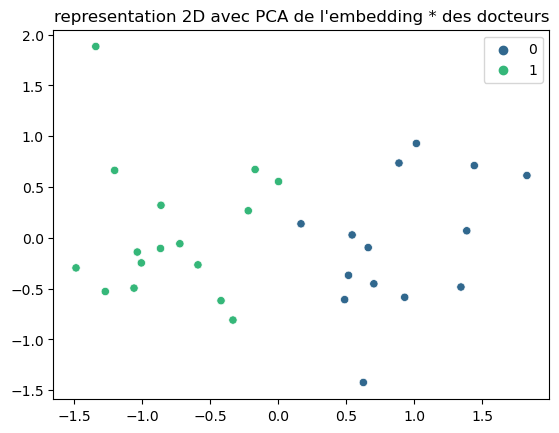

In [354]:
sns.set_palette("deep")
sns.scatterplot( x=doctor_star_pca[:,0], y=doctor_star_pca[:,1], hue=psi_class_star, palette='viridis')
plt.title("representation 2D avec PCA de l'embedding * des docteurs")
plt.show()

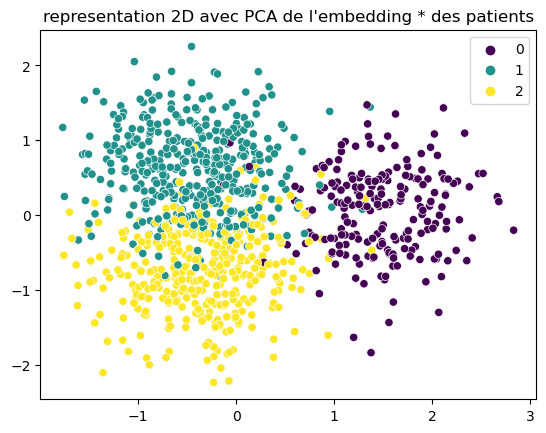

In [358]:
sns.set_palette("deep")
sns.scatterplot( x=patient_star_pca[:,0], y=patient_star_pca[:,1], hue= alpha_class_star, palette='viridis')
plt.title("representation 2D avec PCA de l'embedding * des patients")

plt.show()

##### PCA sur l'embedding estimé

In [309]:
pca = PCA(n_components=2)
patient_hat_pca = pca.fit_transform(patient_embedding_hat)
doctor_hat_pca = pca.fit_transform(doctor_embedding_hat)

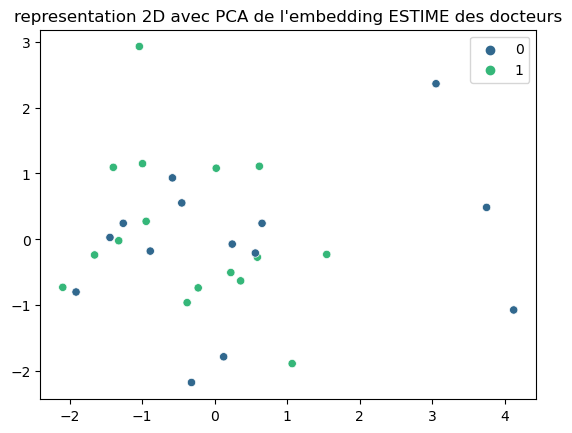

In [311]:
sns.set_palette("deep")
sns.scatterplot( x=doctor_hat_pca[:,0], y=doctor_hat_pca[:,1], hue=psi_class_star, palette='viridis')
plt.title("representation 2D avec PCA de l'embedding ESTIME des docteurs")
plt.show()

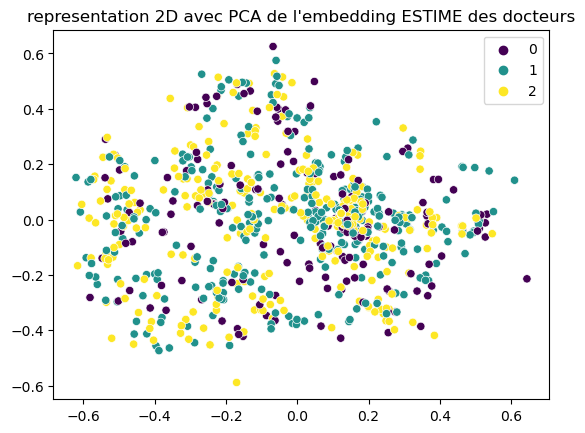

In [314]:
sns.set_palette("deep")
sns.scatterplot( x=patient_hat_pca[:,0], y=patient_hat_pca[:,1], hue= alpha_class_star, palette='viridis')
plt.title("representation 2D avec PCA de l'embedding ESTIME des docteurs")

plt.show()

#### UMAP

We do the same thing with the UMAP algorithm

##### UMAP sur l'embedding * 

In [316]:
patient_star_umap = umap.UMAP(n_components=2,  n_neighbors=15, metric='cosine').fit(alpha_graph_star)
doctor_star_umap = umap.UMAP(n_components=2,  n_neighbors=5, metric='cosine').fit(psi_graph_star)

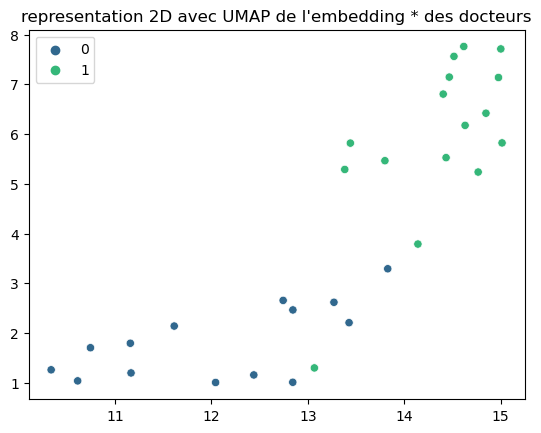

In [360]:
sns.set_palette("deep")
sns.scatterplot( x=doctor_star_umap.embedding_[:,0], y=doctor_star_umap.embedding_[:,1], hue=psi_class_star, palette='viridis')
plt.title("representation 2D avec UMAP de l'embedding * des docteurs")
plt.show()

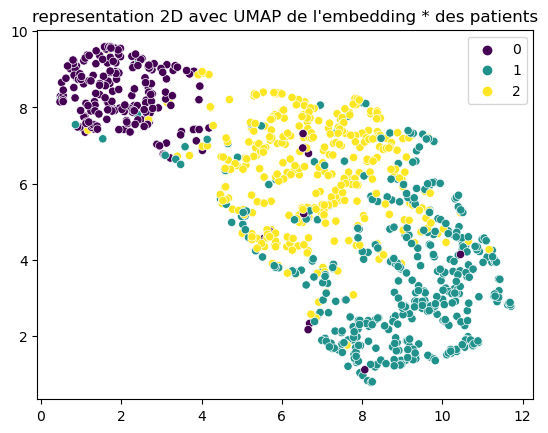

In [366]:
sns.set_palette("deep")
sns.scatterplot( x=patient_star_umap.embedding_[:,0], y=patient_star_umap.embedding_[:,1], hue=alpha_class_star, palette='viridis')
plt.title("representation 2D avec UMAP de l'embedding * des patients")
plt.show()

##### UMAP on the estimated embedding

In [322]:
patient_hat_umap = umap.UMAP(n_components=2, n_neighbors=15, metric='cosine').fit(patient_embedding_hat)
doctor_hat_umap = umap.UMAP(n_components=2,  n_neighbors=5, metric='cosine').fit(doctor_embedding_hat)

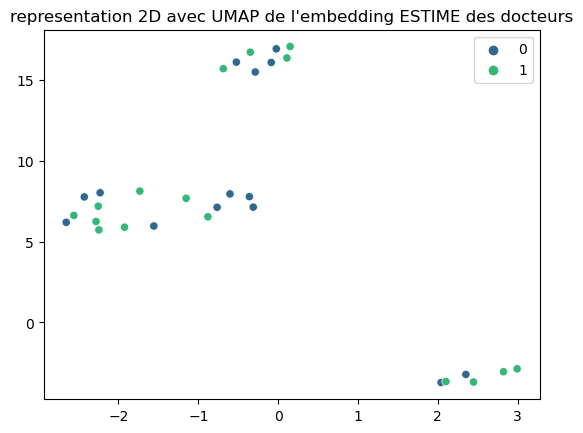

In [323]:
sns.set_palette("deep")
sns.scatterplot( x=doctor_hat_umap.embedding_[:,0], y=doctor_hat_umap.embedding_[:,1], hue=psi_class_star, palette='viridis')
plt.title("representation 2D avec UMAP de l'embedding ESTIME des docteurs")

plt.show()

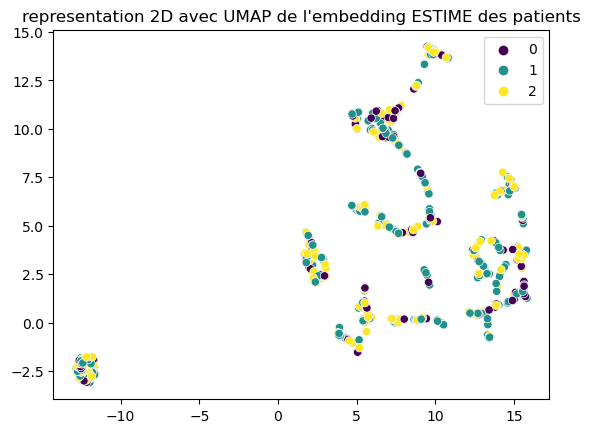

In [324]:
sns.set_palette("deep")
sns.scatterplot( x=patient_hat_umap.embedding_[:,0], y=patient_hat_umap.embedding_[:,1], hue=alpha_class_star, palette='viridis')
plt.title("representation 2D avec UMAP de l'embedding ESTIME des patients")

plt.show()

#### Pacmap

In [381]:
reducer = pacmap.PaCMAP(n_dims=2, n_neighbors=5, MN_ratio=0.5, FP_ratio=2.0) 

In [ ]:
patient_pacmap_hat = reducer.fit_transform(patient_embedding_hat, init="pca")
doctor_pacmap_hat = reducer.fit_transform(doctor_embedding_hat, init="pca")

In [ ]:
sns.set_palette("deep")
sns.scatterplot( x=doctor_umap_hat.embedding_[:,0], y=doctor_umap_hat.embedding_[:,1], hue=links_doctor, palette='viridis')
plt.title("representation 2D avec UMAP de l'embedding des docteurs")

plt.show()

#### Clustering

## HARD Negative Sampling

In [214]:
def hard_negative_sampling_first_step(dataframe,
                                      nb_Y = 1,
                                     ):
    """à partir de notre dataframe, on doit pouvoir générer des Y = 0 pertinents. Pour cela, il faut effectuer un entrainement initial sur notre dataframe pour 
    avoir une première estimation des paramètres de notre modèle (EF, Betas) et ensuite effectuer ce HNS.

    Args:
        dataframe (_type_): Le dataframe initial sur lequel on applique la première étape de notre Hard Negative Sampling.
        nb_Y (int, optional): Le nombre de Y=0 que l'on souhaite échantillonner. Defaults to 1.

    Returns:
        dataframe: Renvoie le dataframe échantillonné.
    """
    df = dataframe.copy()
    # Hard Negative Sampling : 

    # On enregistre l'ensemble des Y = 0 avant de les supprimer de notre dataframe
    negative_connections = df[df['y'] == 0]
    negative_patients = negative_connections['i'].unique()
    # On supprime les Y = 0 car on va les générer avec le HNS
    df.drop(df[df['y'] == 0].index, inplace = True)
    df = df.reset_index(drop=True)
    # D'abord, on effectue l'étape 1 du HNS. Il nous faut une première estimation des EFs/Betas. On garde un Y=0 en se basant sur une distribution dépendant de la
    # popularité/distance à chaque docteur. Pour chaque patient, on garde en mémoire le(s) Y=0 le plus intéressant.
    negative_connections_first_step = negative_connections.copy()
    for i in negative_patients:
        patient_df = negative_connections_first_step[negative_connections_first_step['i'] == i]
        distance = np.zeros(len(patient_df)) # Array pour stocker les distances. Il faut faire attention, indice de l'array =/= indice "réel" du docteur
        popularity = np.zeros(len(patient_df)) # Array pour stocker les popularités
        for j, doctor in enumerate(patient_df['j']):
            distance[j] = patient_df[patient_df['j'] == doctor]['distance'].iloc[0]
            popularity[j] = df[df['j'] == doctor]['y'].sum()
        score = popularity / distance
        score = score/score.sum()
        
        # On conserve les échantillons négatifs les plus significatifs (ceux pour lesquels la probabilité de connexion est la plus grande mais n'a pas eu lieu)
        best_score_array = score.argsort()[-nb_Y:]
        doctors_chosen = patient_df['j'].iloc[best_score_array].to_list()
        doctors_to_eliminate = patient_df[patient_df['j'].isin([j for j in patient_df['j'] if j not in doctors_chosen])]
        negative_connections_first_step.drop(doctors_to_eliminate.index, inplace = True)
    # On a maintenant le Y = 0 désiré pour chaque patient, il faut fusionner les Y = 0 et Y = 1
    return pd.concat([df, negative_connections_first_step]).reset_index(drop=True)

In [216]:
def HNS_and_estimates(dataframe,
                      M,
                      nb_Y = 1,
                      epochs=50,
                      weights=None,
                      threshold_loss=0.01,
                      show_print=0,
                      ):
    """Cette fonction effectue le Hard Negative Sampling (HNS) dans sa globalité et renvoie l'estimation finale des effets fixes, betas.

    Args:
        dataframe (_type_): Le dataframe initial
        M (_type_): Le nombre associé au Top-M docteurs (le paramètre de notre HNS permettant de tirer aléatoirement parmi
        les M docteurs les plus relevants, cf. papier de recherche associé)
        nb_Y (int, optional): Le paramètre Y associé à la première étape du HNS. Defaults to 1.
        epochs (int, optional): paramètre de get_estimations. Defaults to 50.
        weights (_type_, optional): paramètre de get_estimations. Defaults to None.
        threshold_loss (float, optional): paramètre de get_estimations. Defaults to 0.01.

    Returns:
        _type_: l'ensemble des estimations.
    """
    df = dataframe.copy()
    n_patients = dataframe['i'].nunique()
    n_doctors = dataframe['j'].nunique()
    # On récupère le dataframe ayant subi la première étape du HNS
    df_first_hns = hard_negative_sampling_first_step(df, nb_Y)
    
    # On utilise get_first_estimations qui s'occupe d'effectuer la première estimation des EF/Bêtas.
    parameters = get_estimations(df_first_hns, nb_epochs=epochs, initial_weights=weights, target_loss=threshold_loss, show_print=show_print)

    # parameters[2] contient l'ensemble des premières estimations

    # Maintenant, on estime les scores en se servant de la première estimation ci-dessus (https://arxiv.org/abs/2302.03472)
    alpha_graph_training = parameters[1][0]
    psi_graph_training = parameters[1][1]
    beta_age_p_graph_training = parameters[1][2]
    beta_age_d_graph_training = parameters[1][3]
    beta_sex_p_graph_training = parameters[1][4]
    beta_sex_d_graph_training = parameters[1][5]
    beta_distance_graph_training =  parameters[1][6]
    prediction_scores = np.zeros((n_patients, n_doctors))
    negative_drawing_list = []
    # Les scores estimés se basent sur notre modèle de LMF (https://arxiv.org/abs/2302.03472)
    negative_connections = df[df['y'] == 0]
    negative_patients = negative_connections['i'].unique()
    highest_prediction_scores_indexes = np.zeros((len(negative_patients), M))
    # Pour calculer les scores, il faut au préalable récupérer les âges et sexes normalisés.

    df['age_p_normed'] = ( df['age_p'] - df['age_p'].mean() ) / df['age_p'].std()
    df['age_d_normed'] = ( df['age_d'] - df['age_d'].mean() ) / df['age_d'].std()
    df['sex_p_normed'] = ( df['sex_p'] - df['sex_p'].mean() ) / df['sex_p'].std()
    df['sex_d_normed'] = ( df['sex_d'] - df['sex_d'].mean() ) / df['sex_d'].std()

    for i in negative_patients:
        patient_df = negative_connections[negative_connections['i'] == i]
        patient_age_normed = df[df['i'] == i]['age_p_normed'].iloc[0]
        patient_sex_normed = df[df['i'] == i]['sex_p_normed'].iloc[0]
        # On considère les docteurs pour lesquels le patient i n'a pas de connexions avec
        for j in patient_df['j']:
            # on récupère la distance entre le patient i et le docteur j
            distance = patient_df[patient_df['j'] == j]['distance'].iloc[0]
            doctor_age_normed = df[df['j'] == j]['age_d_normed'].iloc[0]
            doctor_sex_normed =df[df['j'] == j]['sex_d_normed'].iloc[0]
            T = np.dot(alpha_graph_training[i], psi_graph_training[j]) + beta_age_p_graph_training * patient_age_normed + beta_age_d_graph_training * doctor_age_normed \
            + beta_sex_p_graph_training * patient_sex_normed + beta_sex_d_graph_training * doctor_sex_normed + beta_distance_graph_training * distance
            prediction_scores[i][j] = 1 / (1 + np.exp(-T))
        # on garde les M indices des docteurs avec la plus grande probabilité de connexion pour le patient i dans highest_prediction_scores_indexes
        highest_prediction_scores_indexes[i] = np.argsort(prediction_scores[i])[-M:]
        # on effectue le negative sampling
        negative_drawing_patient = []
        # on détermine les y = 0 à rajouter à notre dataframe
        negative_drawing = np.random.binomial(1, p=1/M, size=M)
        for l in range(M):
            if negative_drawing[l] == 1:
                doc = highest_prediction_scores_indexes[i][l]
                negative_drawing_patient.append(patient_df[patient_df['j'] == doc].iloc[0].to_list())
        negative_drawing_list += negative_drawing_patient
    # Une fois les connexions négatives récupérées pour chaque patient, on concatène nos Y = 1 et Y = 0
    positive_connections = dataframe.drop(dataframe[dataframe['y'] == 0].index)
    positive_connections = positive_connections.reset_index(drop=True)
    df_second_hns = pd.DataFrame(negative_drawing_list)
    df_second_hns.columns = dataframe.columns
    df_second_hns = pd.concat([positive_connections, df_second_hns], axis = 0)
    df_second_hns = df_second_hns.reset_index(drop=True)
    
    # On effectue maintenant l'estimation finale des EFs/Betas encore une fois à l'aide de Keras mais cette fois-ci sur notre second dataframe
    final_parameters = get_estimations(df_second_hns, nb_epochs=epochs, initial_weights=weights, target_loss=threshold_loss, show_print=show_print)

    return final_parameters

In [218]:
estimates = HNS_and_estimates(df, M=2)
ef_patient = estimates[1][0]
ef_doctor = estimates[1][1]
beta_age_p = estimates[1][2]
beta_age_d = estimates[1][3]
beta_sex_p = estimates[1][4]
beta_sex_d = estimates[1][5]
beta_distance = estimates[1][6]
model = estimates[4]


Training stopped as the loss reached below 0.01


IndexError: index 66 is out of bounds for axis 0 with size 66

array([-9.983393], dtype=float32)

## Métrique Top-N

In [369]:
df2 = graph_formation(n_patients=2000,
                    n_doctors=30,
                    max_number_connections=2,
                    z=0.5,
                    type_distance="default",
                    beta_age_p_graph=0.1,
                    beta_age_d_graph=0.1,
                    beta_sex_p_graph=0.1,
                    beta_sex_d_graph=0.1,
                    beta_distance_graph=-1,
                    nb_latent_factors = 5
                    )
theoric_betas = [0.1, 0.1, 0.1, 0.1, -0.5]
N = 5

In [371]:
df_hns = hard_negative_sampling_first_step(df2, nb_Y=2)

AttributeError: 'tuple' object has no attribute 'copy'

In [ ]:
df_hns['j'].nunique()

In [ ]:
estimates = HNS_and_estimates(df2, M=3, show_print=0)

In [ ]:
estimates[1][0][1]

In [ ]:
def top_N(estimates, theoric_betas, initial_dataframe, N):
    """Étant donné les estimations obtenues par la fonction HNS_and_estimates, la base de données initiale et le paramètre N de la métrique Top-N, top_N calcule le "score" de la prédiction.
    En se basant sur les connexions qui n'ont pas eu lieu, les probas de connexion théoriques/estimées sont calculées puis comparées entre elles (pour chaque patient, on compte
    les N docteurs recommandés par notre système qui sont dans la liste des N docteurs qui ont les probas théoriques les plus élevées de se connecter au patient)

    Args:
        estimates (_type_): L'output obtenu par HNS_and_estimates
        initial_dataframe (_type_): Le dataframe initial, généré par la fonction graph_formation
        theoric_betas: Contient la liste des valeurs théoriques des Beta utilisées pour générer le dataframe [beta_age_p, beta_age_d, beta_sex_p, beta_sex_d, beta_distance]
        N (_type_): le paramètre de la métrique Top-N (le nombre de docteurs qu'on cherche à recommander)
    """
    # Certaines colonnes sont normalisées (optionnel si c'est déjà effectué)
    df = initial_dataframe.copy()
    df['age_p_normed'] = ( df['age_p'] - df['age_p'].mean() ) / df['age_p'].std()
    df['age_d_normed'] = ( df['age_d'] - df['age_d'].mean() ) / df['age_d'].std()
    df['sex_p_normed'] = ( df['sex_p'] - df['sex_p'].mean() ) / df['sex_p'].std()
    df['sex_d_normed'] = ( df['sex_d'] - df['sex_d'].mean() ) / df['sex_d'].std()
    
    n_patients = estimates[1][0].shape[0]
    # n_doctors = estimates[1][1].shape[0]
    embedding_dim = int(len(initial_dataframe.columns[8:])/2)
    beta_age_p_hat = estimates[1][2]
    beta_age_d_hat = estimates[1][3]
    beta_sex_p_hat = estimates[1][4]
    beta_sex_d_hat = estimates[1][5]
    beta_distance_hat = estimates[1][6]
    beta_age_p = theoric_betas[0]
    beta_age_d = theoric_betas[1]
    beta_sex_p = theoric_betas[2]
    beta_sex_d = theoric_betas[3]
    beta_distance = theoric_betas[4]
    negative_connections = df[df['y'] == 0]
    # recommendations = np.zeros((1000, 2, N)) # Utile pour stocker les N recommandations théoriques/estimées
    accuracy = 0
    for i in range(n_patients):
    # Récupérer les différentes estimations à partir d'estimates
        ef_patient_hat = estimates[1][0][i]
        # Récupérer les valeurs théoriques via initial_dataframe
        ef_patient = df[df['i'] == i].iloc[0][8 : 8 + embedding_dim].to_list()
        patient_age_normed = df[df['i'] == i]['age_p_normed'].iloc[0]
        patient_sex_normed = df[df['i'] == i]['sex_p_normed'].iloc[0]
        # Calculer les probas estimées/théoriques avec les docteurs pour lesquels il n'y a pas de connexion
        # On récupère la liste des docteurs avec lesquelles il n'y a pas de connexion
        patient_df = negative_connections[negative_connections['i'] == i]
        doctors_without_connection = patient_df['j'].to_list()
        scores = np.zeros((2, len(doctors_without_connection)))
        for j, doctor in enumerate(doctors_without_connection):
            distance = patient_df[patient_df['j'] == doctor]['distance'].iloc[0]
            ef_doctor_hat = estimates[1][1][doctor]
            ef_doctor = initial_dataframe[initial_dataframe['j'] == doctor].iloc[0][-embedding_dim:].to_list()
            doctor_age_normed = df[df['j'] == doctor]['age_d_normed'].iloc[0]
            doctor_sex_normed =df[df['j'] == doctor]['sex_d_normed'].iloc[0]
            T = np.dot(ef_patient, ef_doctor) + beta_age_p * patient_age_normed + beta_age_d * doctor_age_normed \
                + beta_sex_p * patient_sex_normed + beta_sex_d * doctor_sex_normed + beta_distance * distance
            scores[0][j] = 1 / (1 + np.exp(-T))
            T_hat = np.dot(ef_patient_hat, ef_doctor_hat) + beta_age_p_hat * patient_age_normed + beta_age_d_hat * doctor_age_normed \
                + beta_sex_p_hat * patient_sex_normed + beta_sex_d_hat * doctor_sex_normed + beta_distance_hat * distance
            scores[1][j] = 1 / (1 + np.exp(-T_hat))
        # Garder les N probas estimées/théoriques les plus grandes
        highest_theoretical_scores = np.argsort(scores[0])[-N:]
        highest_estimated_scores = np.argsort(scores[1])[-N:]
        # Compter le nombre de docteurs recommandés qui sont dans les docteurs avec la proba de connexion la plus élevée
        # Il suffit de compter le nombre d'éléments similaires dans highest_theoritical_scores et highest_estimated_scores, sans chercher à retrouver les indices des docteurs recommandés
        # (Il est possible de retrouver les indices avec [doctors_without_connection[i] for i in highest_theoretical_scores] et
        # [doctors_without_connection[i] for i in highest_theoretical_scores] puis les stocker dans recommendations défini au dessus)
        nb_right_predictions = len(set(highest_estimated_scores).intersection(set(highest_theoretical_scores)))
        accuracy += nb_right_predictions / N

    return accuracy/n_patients
    

In [ ]:
accuracy = top_N(estimates, theoric_betas, df2, N=3)

### Cette partie de code est optionnel (la descente de gradient est faite à la main et va beaucoup moins vite que le code ci-dessus)

### Descente de gradient alternée à la main

In [ ]:
def r_ui(df):
    # à partir du dataset y = 0 et y = 1, obtenir la matrice de connexion
    # df2 = df.copy()
    patients = df['i'].unique()
    n_patients = len(patients)
    n_doctors = len(df2['j'].unique())
    R = np.zeros((n_patients, n_doctors))
    for i in patients:
        for j in df[df['i'] == i]['j']:
            connection = df[df['i'] == i][df[df['i'] == i]['j'] == j]['y']
            # if len(connection) > 0:
            if connection[connection.index[0]] == 1:
                R[i][j] = 1
    return R

def alpha(R):
    return np.unique(R.flatten(), return_counts = True)[1][0] / np.unique(R.flatten(), return_counts = True)[1][1] # Nombre de 0 sur nombre de 1

def descente_gradient(df, max_iter, eps = 0.01, lr_patients=0.001, lr_doctors=0.001, reg_term=0.2):
    to_be_normalized_columns = ['age_p', 'age_d', 'sex_p', 'sex_d', 'distance']
    df[to_be_normalized_columns] = ( df[to_be_normalized_columns] - df[to_be_normalized_columns].mean() ) / df[to_be_normalized_columns].std()
    patients = df['i'].unique()
    doctors = df['j'].unique()
    n_patients = len(patients)
    n_doctors = len(doctors)
    nb_latent_factors = len([s for s in df.columns if "ef_p" in s])
    R = r_ui(df)
    alpha_term = alpha(R)
    # We initialise randomly the fixed effects, betas and the bias
    X = np.random.uniform(-1, 1, size = (n_patients, nb_latent_factors))
    Y = np.random.uniform(-1, 1, size = (n_doctors, nb_latent_factors))
    beta_age_doctor = np.random.uniform(-0.5, 0.5)
    beta_age_patient = np.random.uniform(-0.5, 0.5)
    beta_sex_doctor = np.random.uniform(-0.5, 0.5)
    beta_sex_patient = np.random.uniform(-0.5, 0.5)
    beta_distance = np.random.uniform(-0.5, 0.5)
    grad_X = np.zeros((n_patients, nb_latent_factors)) # Matrix containin fixed effects gradients of patients
    grad_Y = np.zeros((n_doctors, nb_latent_factors)) # Matrix containing fixed effects gradients of doctors
    grad_beta_age_doctor = 0
    grad_beta_sex_doctor = 0
    grad_beta_age_patient = 0
    grad_beta_sex_patient = 0
    grad_beta_distance = 0
    sum_squared_sgd_ef_patients = [0 for _ in range(n_patients)]
    sum_squared_sgd_ef_doctors = [0 for _ in range(n_doctors)]
    sum_squared_sgd_beta_age_doctor = 0
    sum_squared_sgd_beta_sex_doctor = 0
    sum_squared_sgd_beta_age_patient = 0
    sum_squared_sgd_beta_sex_patient = 0
    sum_squared_sgd_beta_distance = 0

    k = 0
    first_loop = True # Allows the while loop to run the first time
    while ( np.linalg.norm(grad_X) > eps or np.linalg.norm(grad_Y) > eps or first_loop == True ) and \
    k < max_iter : # Alternate gradient descent
        first_loop = False
        t_0 = time.time()
        k += 1
        grad_beta_age_doctor = 0
        grad_beta_sex_doctor = 0
        for j in doctors: # We fix fixed effects / bias of the patients and update the one of the doctors
            grad_Y[j, :] = 0 # We reinitialize at each loop the gradients
            for i in df[df['j'] == j]['i']:

                sex_patient = df[df['i'] == i]['sex_p'].iloc[0]
                sex_doctor = df[df['j'] == j]['sex_d'].iloc[0]
                age_patient = df[df['i'] == i]['age_p'].iloc[0]
                age_doctor = df[df['j'] == j]['age_d'].iloc[0]
                distance = df[df['i'] == i][df[df['i'] == i]['j'] == j]['distance'].iloc[0]
                # Following terms are defined to optimize calculation time
                exp_term = (1 + alpha_term*R[i][j]) / (1 + np.exp(-(np.dot(X[i, :], Y[j, :]) + \
                age_patient * beta_age_patient + sex_patient * beta_sex_patient + age_doctor * beta_age_doctor + sex_doctor * beta_sex_doctor + distance * beta_distance )))
                alpha_r = alpha_term*R[i][j]
                
                grad_Y[j, :] += -alpha_r*X[i, :] + X[i, :] * exp_term + reg_term*Y[j, :]
                
                grad_beta_age_doctor += age_doctor*(-alpha_r + exp_term)

                grad_beta_sex_doctor += sex_doctor*(-alpha_r + exp_term)


            # Sum of terms in the denominator for Adaboost
            sum_squared_sgd_ef_doctors[j] += (np.dot(grad_Y[j, :], grad_Y[j, :])) 
            Y[j, :] -= lr_doctors*grad_Y[j, :]/np.sqrt(sum_squared_sgd_ef_doctors[j])

        sum_squared_sgd_beta_age_doctor += grad_beta_age_doctor**2
        sum_squared_sgd_beta_sex_doctor += grad_beta_sex_doctor**2
        beta_age_doctor -= lr_doctors*grad_beta_age_doctor/np.sqrt(sum_squared_sgd_beta_age_doctor)
        beta_sex_doctor -= lr_doctors*grad_beta_sex_doctor/np.sqrt(sum_squared_sgd_beta_sex_doctor)


        grad_beta_age_patient = 0 # We reinitialize at each loop the gradients
        grad_beta_sex_patient = 0
        for i in patients: # We now update fixed effects / bias of the patients using our updated fixed effects / bias of doctors
            grad_X[i, :] = 0 # We reinitialize at each loop the gradients
            for j in df[df['i'] == i]['j']:

                sex_patient = df[df['i'] == i]['sex_p'].iloc[0]
                sex_doctor = df[df['j'] == j]['sex_d'].iloc[0]
                age_patient = df[df['i'] == i]['age_p'].iloc[0]
                age_doctor = df[df['j'] == j]['age_d'].iloc[0]
                distance = df[df['i'] == i][df[df['i'] == i]['j'] == j]['distance'].iloc[0]
                # Following terms are defined to optimize calculation time
                exp_term = (1 + alpha_term*R[i][j]) / (1 + np.exp(-(np.dot(X[i, :], Y[j, :]) + \
                age_patient * beta_age_patient + sex_patient * beta_sex_patient + age_doctor * beta_age_doctor + sex_doctor * beta_sex_doctor + distance * beta_distance )))
                alpha_r = alpha_term*R[i][j]
                
                grad_X[i, :] += -alpha_r * Y[j, :] + Y[j, :] * exp_term + reg_term*X[i, :]

                grad_beta_age_patient += age_patient * (-alpha_r + exp_term)

                grad_beta_sex_patient += sex_patient * (-alpha_r + exp_term)
                
            sum_squared_sgd_ef_patients[i] += (np.dot(grad_X[i, :], grad_X[i, :])) # Denominator term for Adaboost
            X[i, :] -= lr_patients*grad_X[i, :]/np.sqrt(sum_squared_sgd_ef_patients[i])

        sum_squared_sgd_beta_age_patient += grad_beta_age_patient**2
        sum_squared_sgd_beta_sex_patient += grad_beta_sex_patient**2
        beta_age_patient -= lr_patients*grad_beta_age_patient/np.sqrt(sum_squared_sgd_beta_age_patient)
        beta_sex_patient -= lr_patients*grad_beta_age_patient/np.sqrt(sum_squared_sgd_beta_sex_patient)

        grad_beta_distance = 0
        for i in patients: # We finally update the beta_distance as it is dependent on patients and doctors parameters.
            for j in df[df['i'] == i]['j']:

                sex_patient = df[df['i'] == i]['sex_p'].iloc[0]
                sex_doctor = df[df['j'] == j]['sex_d'].iloc[0]
                age_patient = df[df['i'] == i]['age_p'].iloc[0]
                age_doctor = df[df['j'] == j]['age_d'].iloc[0]
                distance = df[df['i'] == i][df[df['i'] == i]['j'] == j]['distance'].iloc[0]
                exp_term = (1 + alpha_term*R[i][j]) / (1 + np.exp(-(np.dot(X[i, :], Y[j, :]) + \
                age_patient * beta_age_patient + sex_patient * beta_sex_patient + age_doctor * beta_age_doctor + sex_doctor * beta_sex_doctor + distance * beta_distance )))
                alpha_r = alpha_term*R[i][j]
                
                grad_beta_distance += distance*(-alpha_r + exp_term)
            
        sum_squared_sgd_beta_distance += grad_beta_distance**2
        beta_distance -= ((lr_patients + lr_doctors)/2)*grad_beta_distance/np.sqrt(sum_squared_sgd_beta_distance)
        t_1 = time.time()

        print(k, "-th iteration took", t_1 - t_0, "to execute.")
    beta = [beta_age_doctor, beta_sex_doctor, beta_age_patient, beta_sex_patient, beta_distance]
    grad_beta = [grad_beta_age_doctor, grad_beta_sex_doctor, grad_beta_age_patient, grad_beta_sex_patient, grad_beta_distance]
    return ([X, Y, beta], [grad_X, grad_Y, grad_beta])
        

In [ ]:
df = graph_formation(n_patients=100,
                    n_doctors=30,
                    max_number_connections=4,
                    z=0.5,
                    type_distance="default",
                    beta_age_p_graph=0.01,
                    beta_age_d_graph=0.01,
                    beta_sex_p_graph=0.1,
                    beta_sex_d_graph=0.1,
                    beta_distance_graph=-10,
                    alpha_law_graph=(-1, 1),
                    psi_law_graph=(-1, 1),
                    nb_latent_factors = 5
                    )

In [ ]:
dataframe = df.copy()
positive_connections = dataframe[dataframe['y'] == 1]
negative_connections = dataframe[dataframe['y'] == 0]
len(negative_connections['i'].unique())

In [ ]:
# Nombre de non connexions par patient en moyenne
negative_connections['i'].value_counts().mean()

In [ ]:
# M doit être inférieur ou égal à cette valeur
# C'est le plus petit nombre de docteurs auquel un patient i n'est pas connecté
negative_connections['i'].value_counts().min()

In [ ]:
# On a bien plus de connexions négatives que de connexions positives
positive_connections['i'].value_counts()

In [ ]:
# Nombre de connexions par patient en moyenne
positive_connections['i'].value_counts().mean()

In [ ]:
df = graph_formation_hns(n_patients=1000,
                    n_doctors=300,
                    max_number_connections=5,
                    z=0.5,
                    M=30,
                    type_distance="default",
                    beta_age_p_graph=0.01,
                    beta_age_d_graph=0.01,
                    beta_sex_p_graph=0.1,
                    beta_sex_d_graph=0.1,
                    beta_distance_graph=-10,
                    alpha_law_graph=(-1, 1),
                    psi_law_graph=(-1, 1),
                    nb_latent_factors = 5
                    )

In [ ]:
df

In [ ]:
# Comparaison Y = 0 / Y = 1, pas assez d'échantillonnage négatif ?
df['y'].value_counts()

In [ ]:
estimation = descente_gradient(df = df,
                               eps = 0.1,
                               lr_patients=0.01,
                               lr_doctors=0.01,
                               max_iter = 100)

In [ ]:
estimation[1][0]